In [1]:
import pandas as pd
import numpy as np
import arviz as az
import altair as alt
from scipy import stats
import pymc as pm
from dotenv import load_dotenv

load_dotenv("/Users/rhilly/intuitive-bayes/env_vars.env")
az.style.use('arviz-darkgrid')

In [30]:
penguins = pd.read_csv("https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/penguins.csv")

In [3]:
RANDOM_SEED = 8296
np.random.seed(RANDOM_SEED)

In [4]:
penguins.sample(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
194,Gentoo,Biscoe,45.3,13.7,210.0,4300.0,female,2008
243,Gentoo,Biscoe,52.2,17.1,228.0,5400.0,male,2009
168,Gentoo,Biscoe,42.0,13.5,210.0,4150.0,female,2007
257,Gentoo,Biscoe,46.8,16.1,215.0,5500.0,male,2009
98,Adelie,Dream,33.1,16.1,178.0,2900.0,female,2008
238,Gentoo,Biscoe,43.4,14.4,218.0,4600.0,female,2009
159,Gentoo,Biscoe,46.7,15.3,219.0,5200.0,male,2007
322,Chinstrap,Dream,50.1,17.9,190.0,3400.0,female,2009
70,Adelie,Torgersen,33.5,19.0,190.0,3600.0,female,2008
123,Adelie,Torgersen,41.4,18.5,202.0,3875.0,male,2009


For now, we're just going to focus on the Adelie penguins:

In [5]:
adelie = penguins.query("species == 'Adelie'")

In [6]:
adelie.sample(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
144,Adelie,Dream,37.3,16.8,192.0,3000.0,female,2009
108,Adelie,Biscoe,38.1,17.0,181.0,3175.0,female,2009
48,Adelie,Dream,36.0,17.9,190.0,3450.0,female,2007
63,Adelie,Biscoe,41.1,18.2,192.0,4050.0,male,2008
34,Adelie,Dream,36.4,17.0,195.0,3325.0,female,2007
125,Adelie,Torgersen,40.6,19.0,199.0,4000.0,male,2009
50,Adelie,Biscoe,39.6,17.7,186.0,3500.0,female,2008
132,Adelie,Dream,36.8,18.5,193.0,3500.0,female,2009
83,Adelie,Torgersen,35.1,19.4,193.0,4200.0,male,2008
89,Adelie,Dream,38.9,18.8,190.0,3600.0,female,2008


In [7]:
(
    alt.Chart(adelie.query("sex.notnull()"))
    .mark_boxplot()
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.Y(alt.repeat("row"), type="nominal")
    )
    .repeat(
        row=["sex"],
        column=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
    )
)

/Users/rhilly/mambaforge/envs/analytics/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

In [8]:
(
    alt.Chart(adelie.query("sex.notnull()"))
    .mark_point()
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.Y(alt.repeat("row"), type="quantitative"),
        color="sex"
    )
    .repeat(
        row=["body_mass_g"],
        column=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
    )
)

alt.RepeatChart(...)

In [9]:
adelie_complete = adelie.dropna()

In [10]:
with pm.Model() as adelie_body_mass_intercept:
    intercept = pm.Normal("intercept", mu=3000, sigma=500)
    eps = pm.HalfNormal("eps", sigma=500)
    
    body_mass_g = pm.Normal(
        "body_mass_g",
        mu=intercept,
        sigma=eps,
        observed=adelie_complete["body_mass_g"].values
    )

In [11]:
with adelie_body_mass_intercept:
    adelie_body_mass_idata = pm.sample()
    adelie_body_mass_idata.extend(pm.sample_prior_predictive())
    adelie_body_mass_idata.extend(pm.sample_posterior_predictive(adelie_body_mass_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


<AxesSubplot: xlabel='body_mass_g / body_mass_g'>

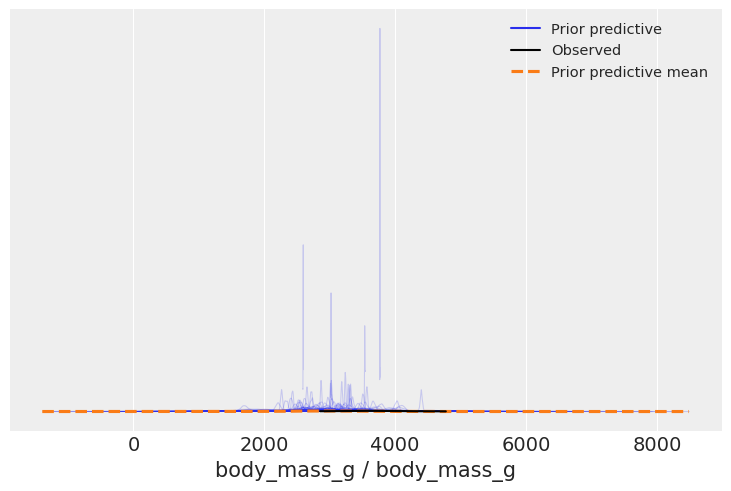

In [12]:
az.plot_ppc(adelie_body_mass_idata, group="prior")

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'eps'}>,
        <AxesSubplot: title={'center': 'eps'}>]], dtype=object)

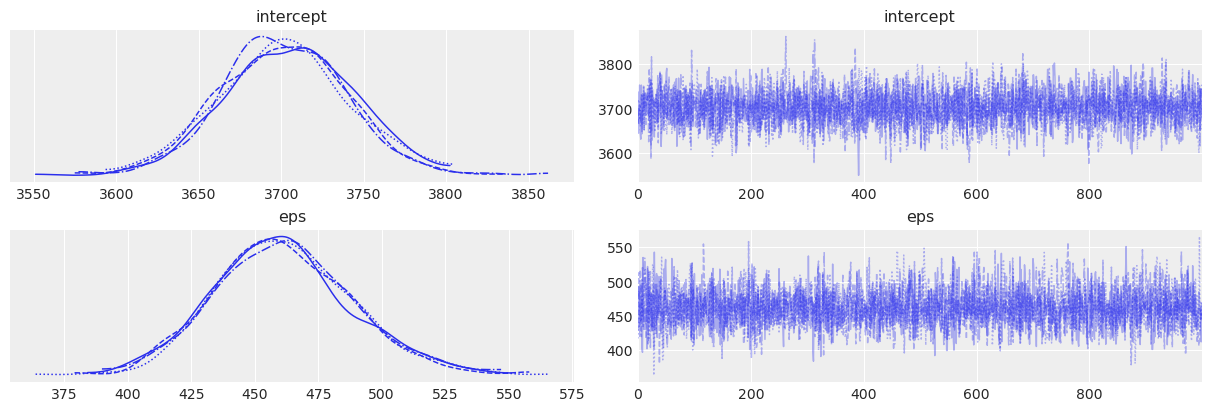

In [13]:
az.plot_trace(adelie_body_mass_idata)

<AxesSubplot: xlabel='body_mass_g / body_mass_g'>

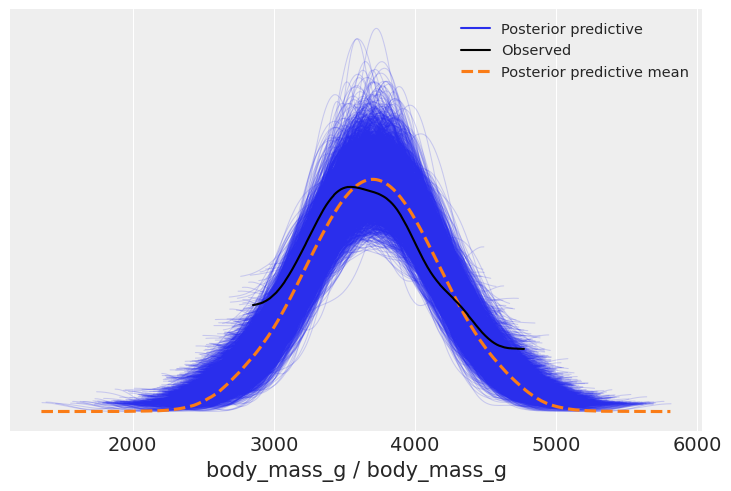

In [14]:
az.plot_ppc(adelie_body_mass_idata, group="posterior")

array([<AxesSubplot: title={'center': 'intercept'}>,
       <AxesSubplot: title={'center': 'eps'}>], dtype=object)

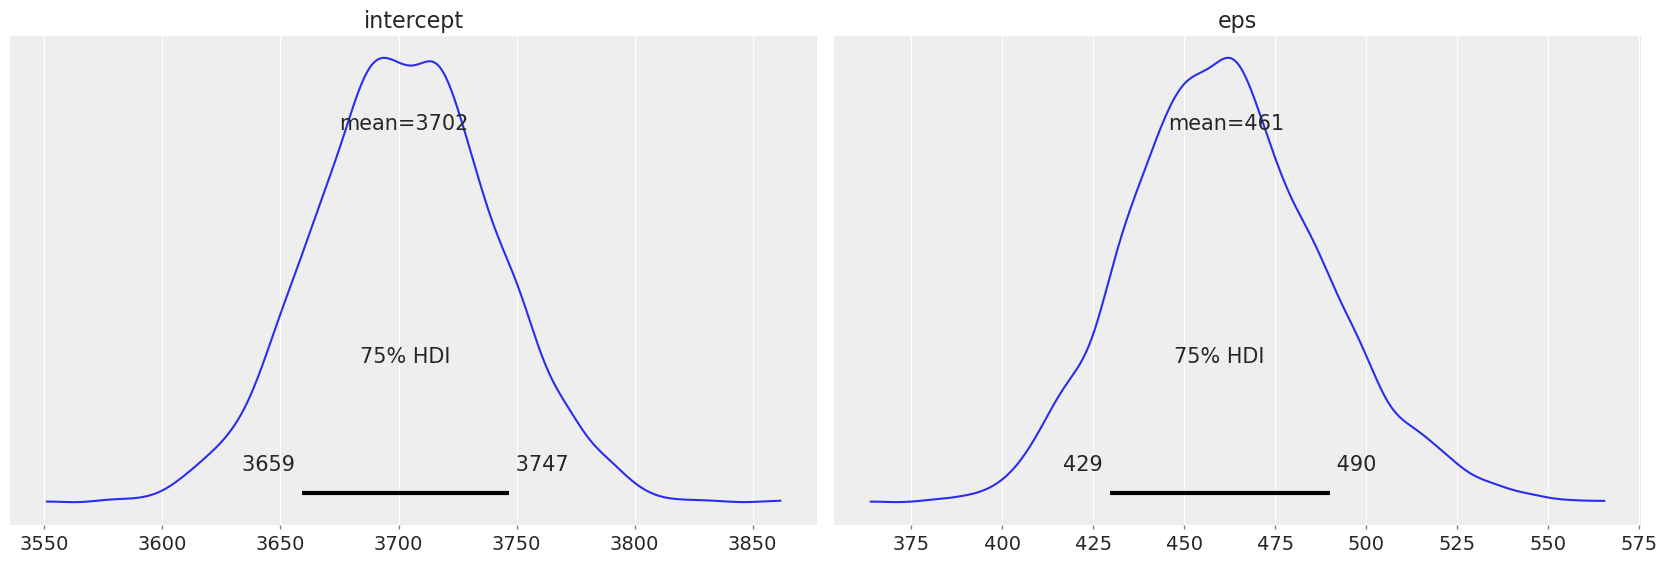

In [15]:
az.plot_posterior(adelie_body_mass_idata, hdi_prob=0.75)

## Exercise 2: Adding regressors

In [16]:
COORDS = {
    "slopes": ["bill_length_mm_effect", "bill_depth_mm_effect"]
}

In [17]:
with pm.Model(coords=COORDS) as adelie_bill_length:
    bill_length_mm = pm.ConstantData("bill_length_mm", adelie_complete["bill_length_mm"].values)
    body_mass_g = pm.ConstantData("body_mass_g", adelie_complete["body_mass_g"].values)
    
    intercept = pm.Normal("intercept", mu=3000, sigma=500)
    beta = pm.Normal("beta", mu=50, sigma=0.5)
    
    mu = intercept + beta * bill_length_mm
    
    eps = pm.HalfNormal("eps", sigma=500)
    
    body_mass_adelie = pm.Normal(
        "body_mass_adelie",
        mu=mu,
        sigma=eps,
        observed=body_mass_g
    )

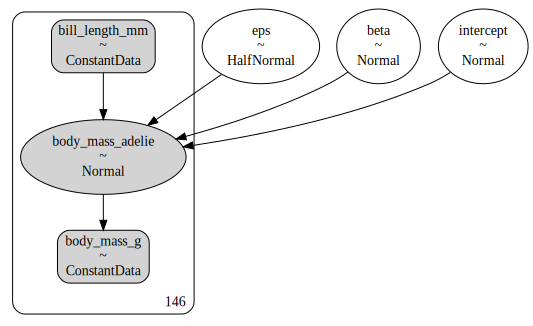

In [18]:
pm.model_to_graphviz(adelie_bill_length)

In [19]:
with adelie_bill_length:
    adelie_body_mass_idata = pm.sample()
    adelie_body_mass_idata.extend(pm.sample_prior_predictive())
    adelie_body_mass_idata.extend(pm.sample_posterior_predictive(adelie_body_mass_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'eps'}>,
        <AxesSubplot: title={'center': 'eps'}>]], dtype=object)

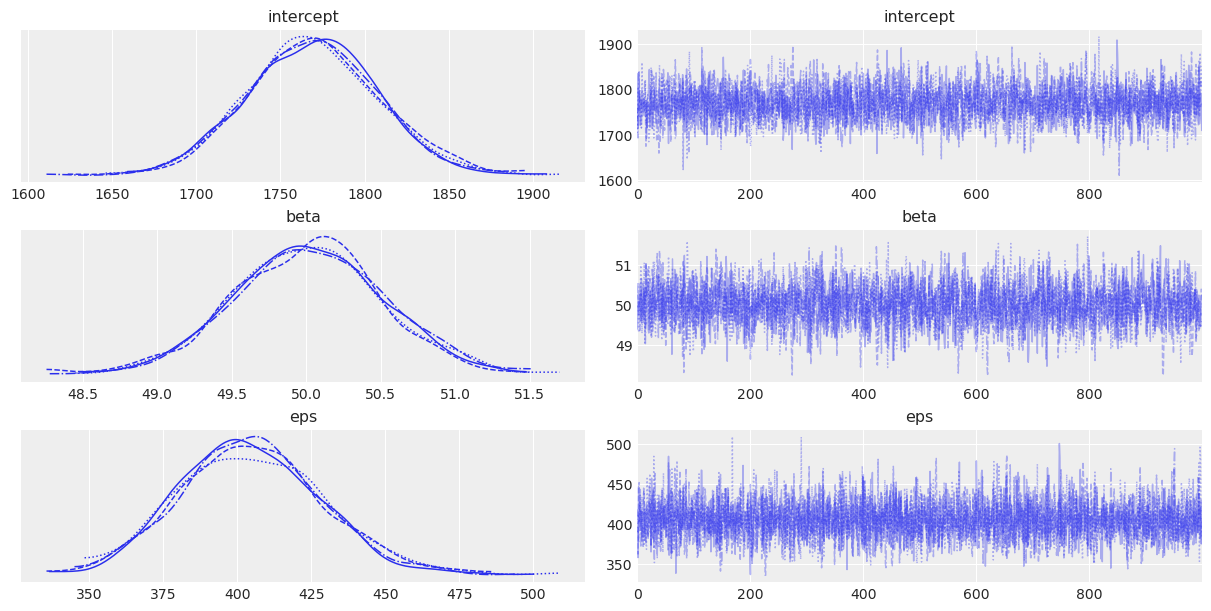

In [20]:
az.plot_trace(adelie_body_mass_idata)

<AxesSubplot: xlabel='body_mass_adelie / body_mass_adelie'>

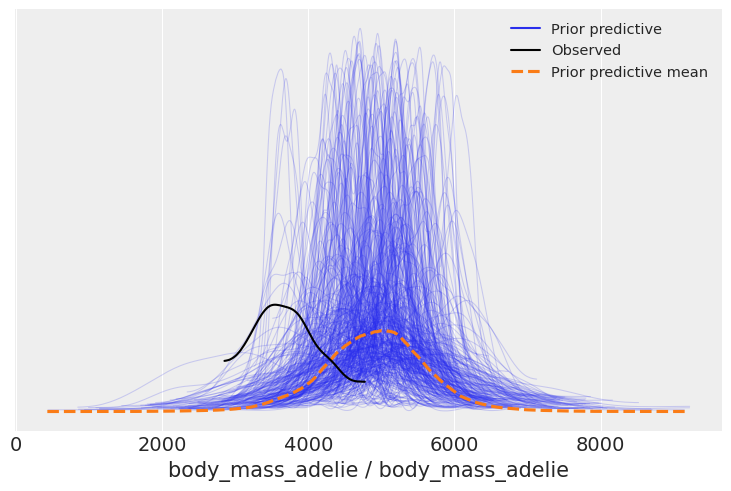

In [21]:
az.plot_ppc(adelie_body_mass_idata, group="prior")

<AxesSubplot: xlabel='body_mass_adelie / body_mass_adelie'>

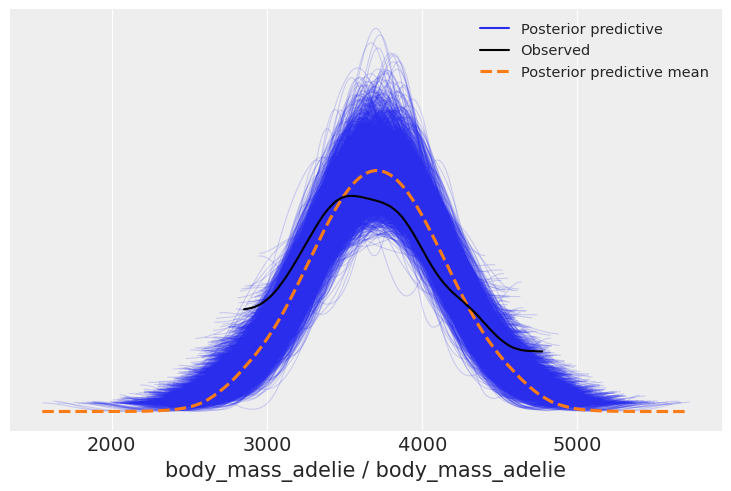

In [22]:
az.plot_ppc(adelie_body_mass_idata, group="posterior")

Ok, so it does seem that you can place priors for multiple beta in the same object:

In [58]:
with pm.Model(coords=COORDS) as adelie_bill_length_and_depth:
    bill_length_mm = pm.ConstantData("bill_length_mm", adelie_complete["bill_length_mm"].values)
    bill_depth_mm = pm.ConstantData("bill_depth_mm", adelie_complete["bill_depth_mm"].values)
    body_mass_g = pm.ConstantData("body_mass_g", adelie_complete["body_mass_g"].values)
    
    intercept = pm.Normal("intercept", mu=3000, sigma=500)
    beta = pm.Normal("beta", mu=50, sigma=0.5, dims="slopes")
    eps = pm.HalfNormal("eps", sigma=500)
    
    mu = pm.Deterministic(
        "mu",
        intercept +
        beta[0] * bill_length_mm +
        beta[1] * bill_depth_mm
    )
    
    body_mass_adelie = pm.Normal(
        "body_mass_adelie",
        mu=mu,
        sigma=eps,
        observed=body_mass_g
    )

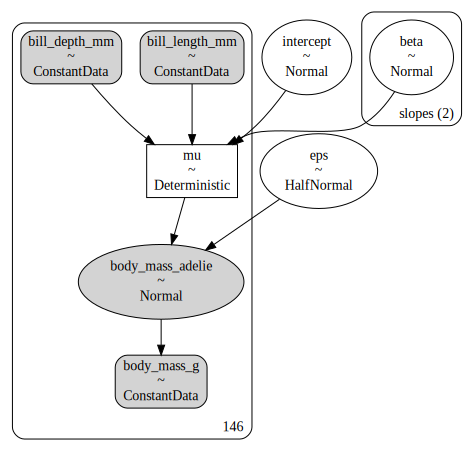

In [59]:
pm.model_to_graphviz(adelie_bill_length_and_depth)

In [60]:
with adelie_bill_length_and_depth:
    adelie_body_mass_idata = pm.sample()
    adelie_body_mass_idata.extend(pm.sample_prior_predictive())
    adelie_body_mass_idata.extend(pm.sample_posterior_predictive(adelie_body_mass_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [61]:
adelie_body_mass_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'eps'}>,
        <AxesSubplot: title={'center': 'eps'}>]], dtype=object)

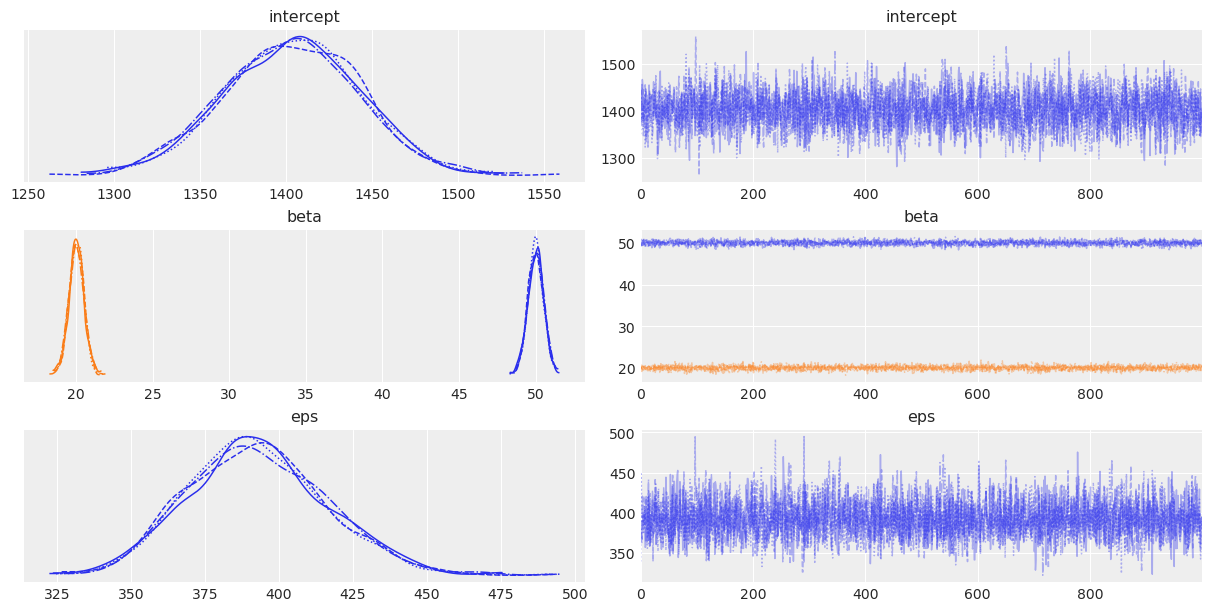

In [26]:
az.plot_trace(adelie_body_mass_idata)

<AxesSubplot: xlabel='body_mass_adelie / body_mass_adelie'>

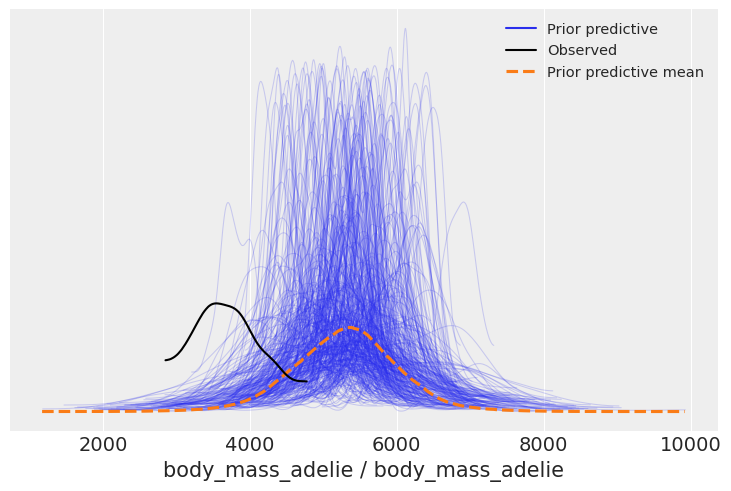

In [27]:
az.plot_ppc(adelie_body_mass_idata, group="prior")

<AxesSubplot: xlabel='body_mass_adelie / body_mass_adelie'>

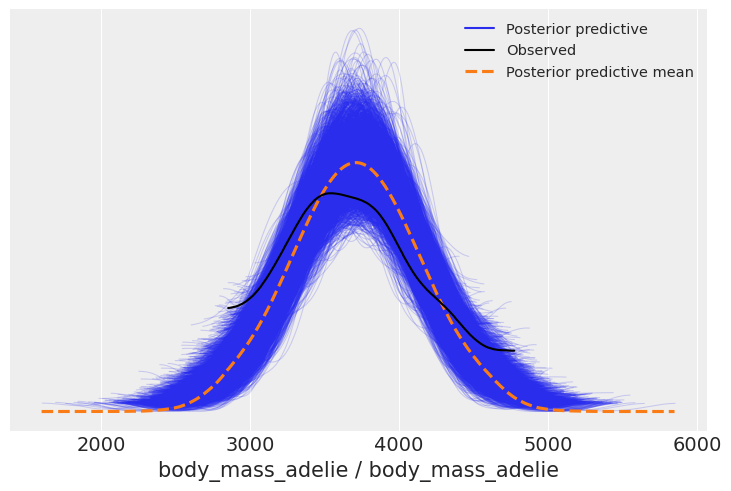

In [28]:
az.plot_ppc(adelie_body_mass_idata, group="posterior")

## Exercise 3

In [33]:
penguins_complete = penguins.dropna()

In [38]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [37]:
species_idx, species = penguins_complete["species"].factorize(sort=True)
COORDS["species"] = species

In [39]:
COORDS

{'slopes': ['bill_length_mm_effect', 'bill_depth_mm_effect'],
 'species': Index(['Adelie', 'Chinstrap', 'Gentoo'], dtype='object')}

In [42]:
with pm.Model(coords=COORDS) as penguins_full_model:
    bill_length_mm = pm.ConstantData("bill_length_mm", penguins_complete["bill_length_mm"].values)
    bill_depth_mm = pm.ConstantData("bill_depth_mm", penguins_complete["bill_depth_mm"].values)
    body_mass_g = pm.ConstantData("body_mass_g", penguins_complete["body_mass_g"].values)
    species_idx_ = pm.ConstantData("species_idx_", species_idx)
    
    intercept = pm.Normal("intercept", mu=3000, sigma=500, dims="species")
    beta = pm.Normal("beta", mu=[50, 20], sigma=0.5, dims=("species", "slopes"))
    eps = pm.HalfNormal("eps", sigma=500)
    
    mu = (
        intercept[species_idx_] +
        beta[species_idx_, 0] * bill_length_mm +
        beta[species_idx_, 1] * bill_depth_mm
    )
    
    body_mass_penguins = pm.Normal(
        "body_mass_penguins",
        mu=mu,
        sigma=eps,
        observed=body_mass_g
    )

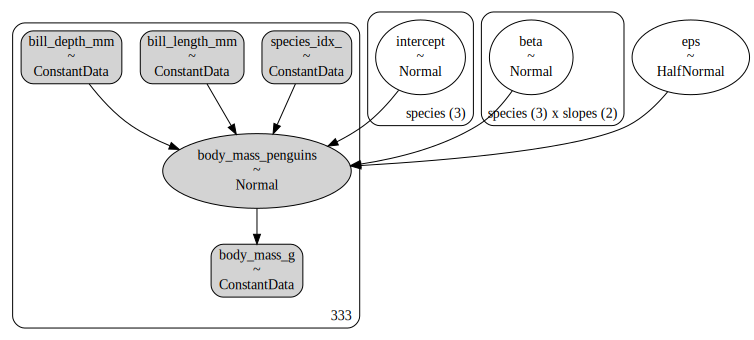

In [43]:
pm.model_to_graphviz(penguins_full_model)

In [44]:
with penguins_full_model:
    penguins_full_idata = pm.sample()
    penguins_full_idata.extend(pm.sample_prior_predictive())
    penguins_full_idata.extend(pm.sample_posterior_predictive(penguins_full_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'eps'}>,
        <AxesSubplot: title={'center': 'eps'}>]], dtype=object)

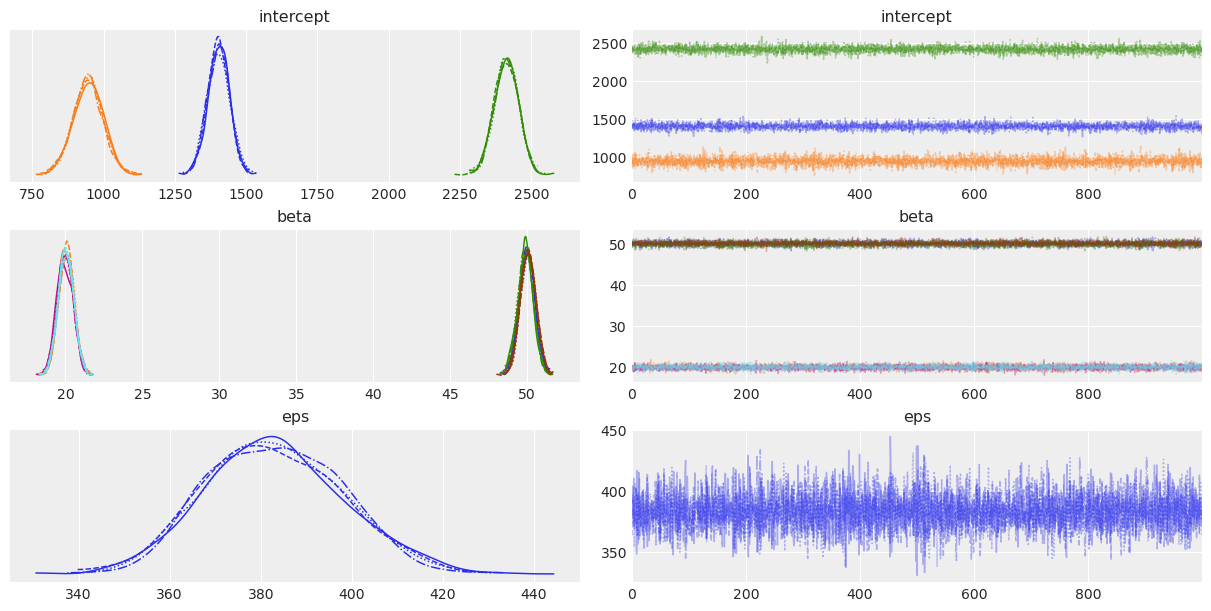

In [45]:
az.plot_trace(penguins_full_idata)

array([[<AxesSubplot: title={'center': 'intercept\nAdelie'}>,
        <AxesSubplot: title={'center': 'intercept\nChinstrap'}>,
        <AxesSubplot: title={'center': 'intercept\nGentoo'}>],
       [<AxesSubplot: title={'center': 'beta\nAdelie, bill_length_mm_effect'}>,
        <AxesSubplot: title={'center': 'beta\nAdelie, bill_depth_mm_effect'}>,
        <AxesSubplot: title={'center': 'beta\nChinstrap, bill_length_mm_effect'}>],
       [<AxesSubplot: title={'center': 'beta\nChinstrap, bill_depth_mm_effect'}>,
        <AxesSubplot: title={'center': 'beta\nGentoo, bill_length_mm_effect'}>,
        <AxesSubplot: title={'center': 'beta\nGentoo, bill_depth_mm_effect'}>],
       [<AxesSubplot: title={'center': 'eps'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

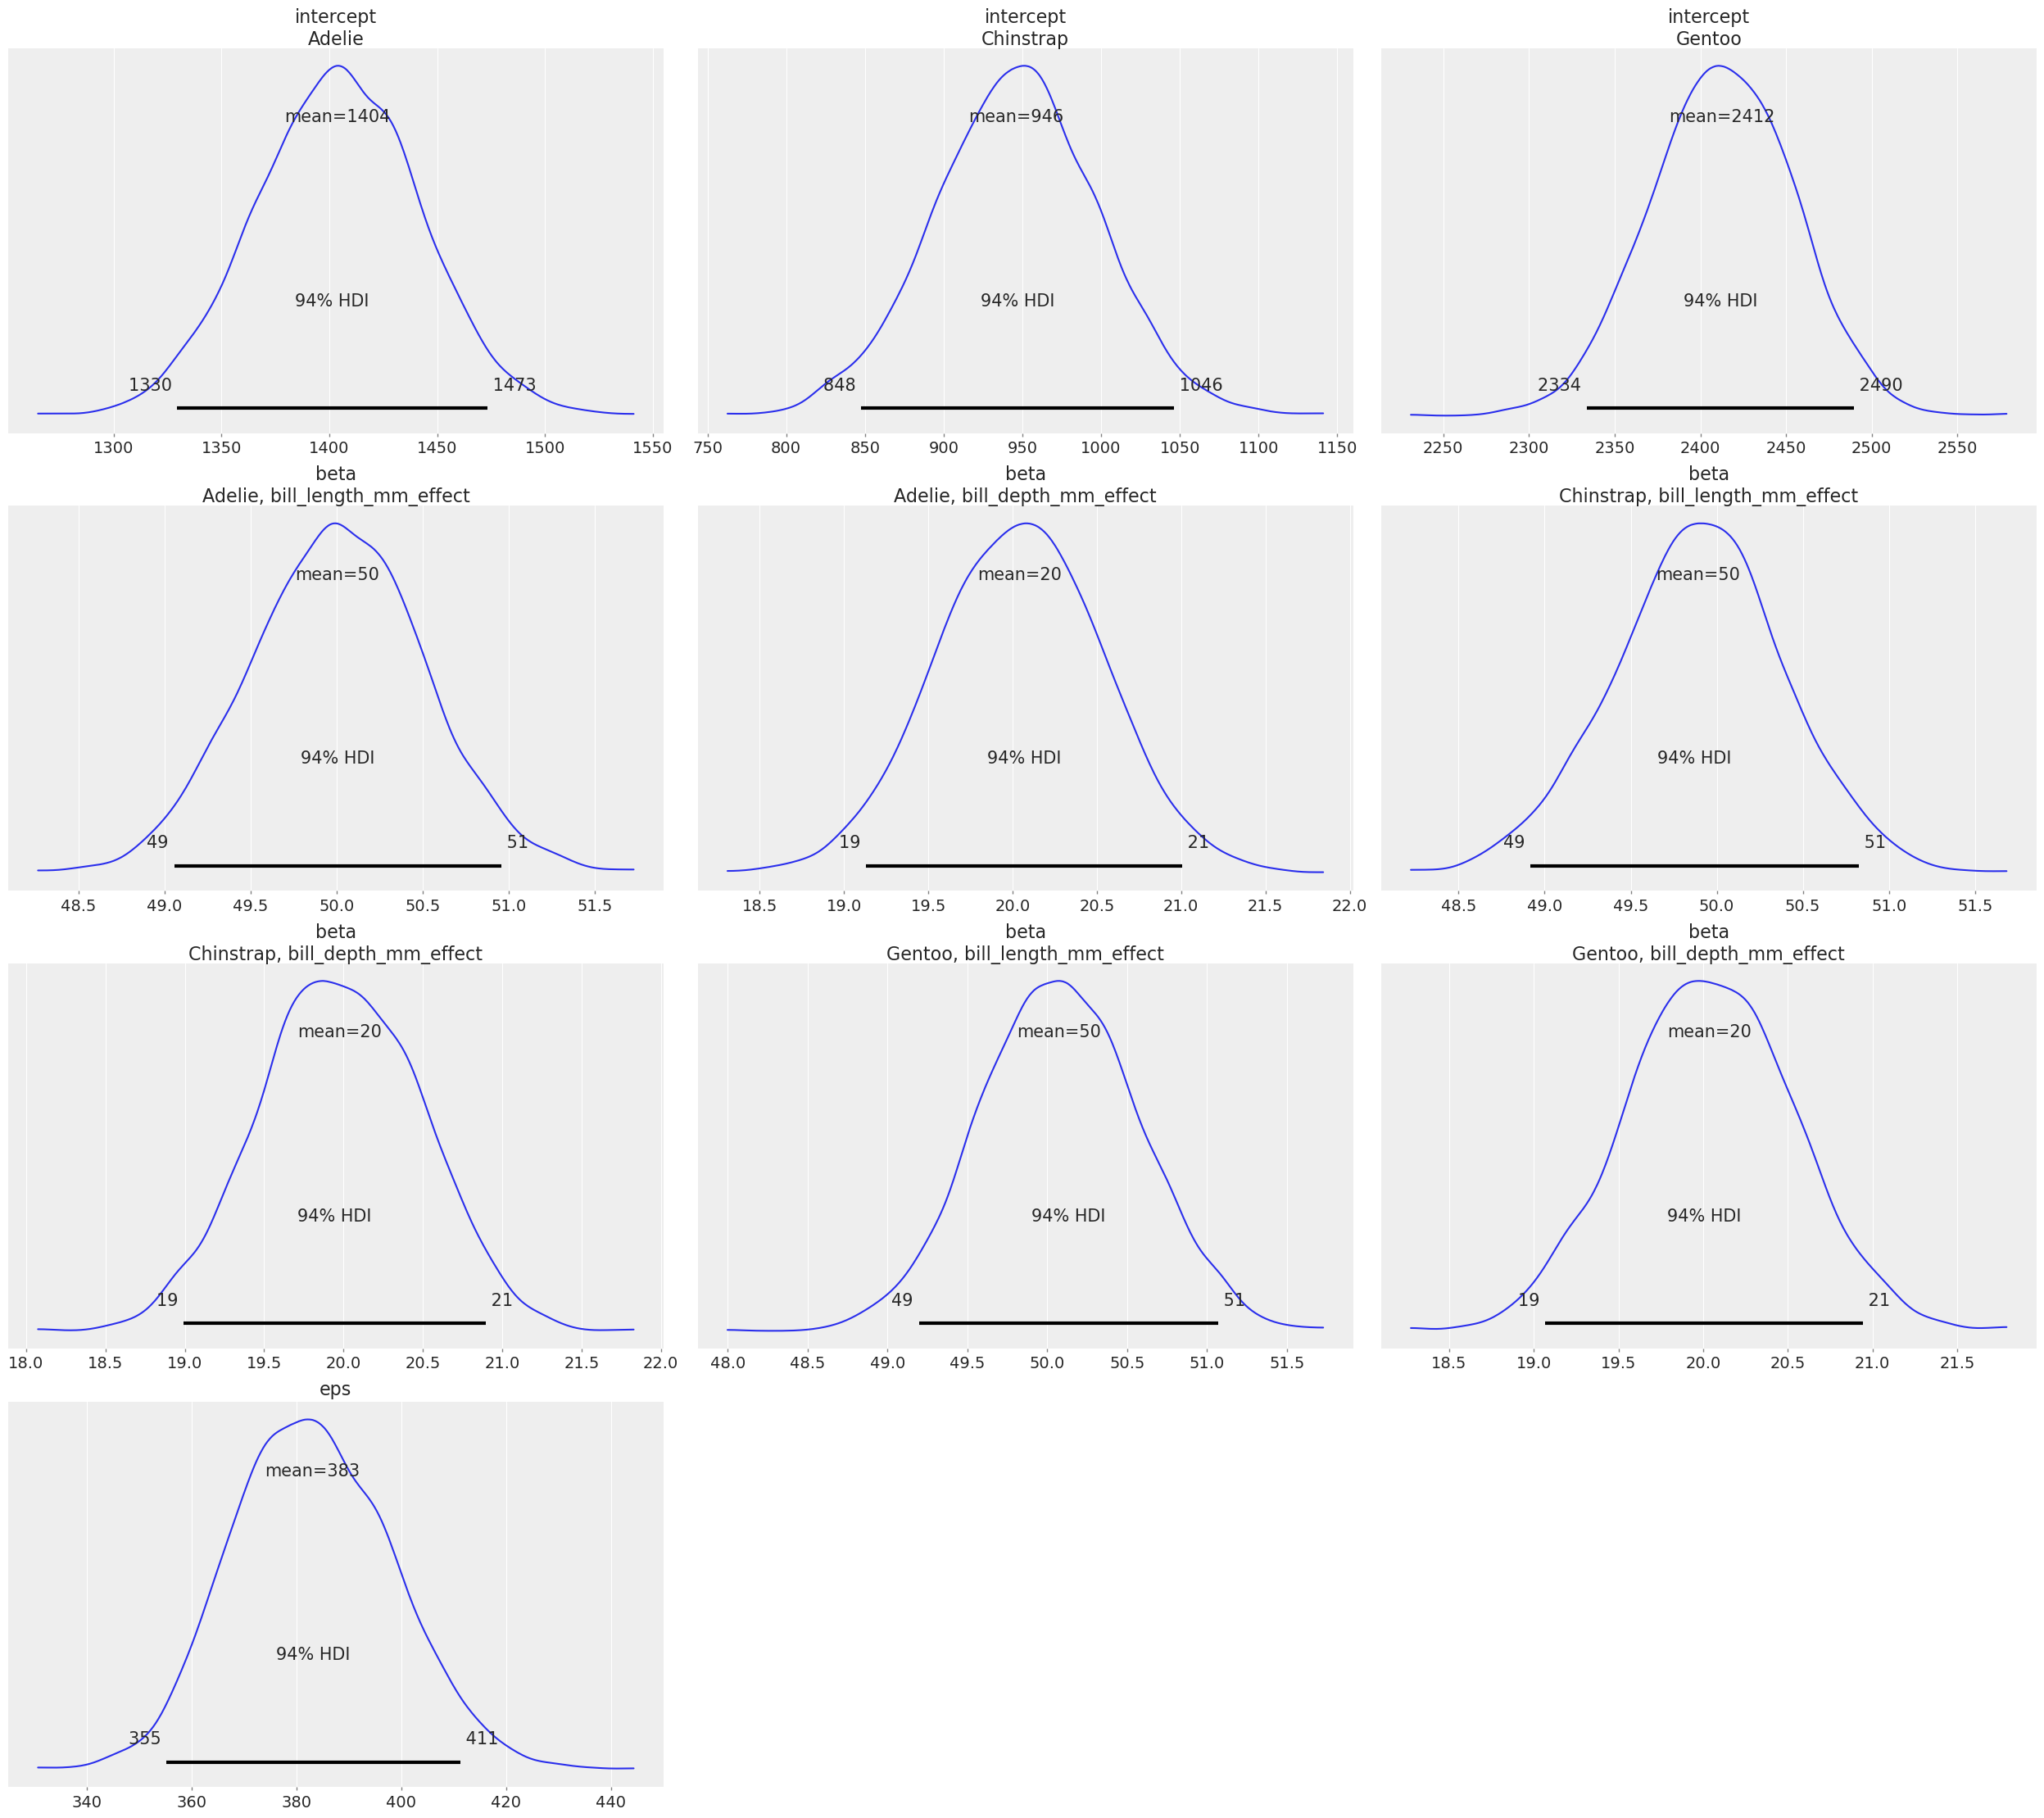

In [47]:
az.plot_posterior(penguins_full_idata, hdi_prob=0.94)

In [51]:
penguins_full_idata.sel(species="Adelie")["posterior"]["beta"]

<xarray.DataArray 'beta' (chain: 4, draw: 1000, slopes: 2)>
array([[[51.00162417, 18.90794241],
        [49.65190914, 20.01451638],
        [50.20256777, 20.08130579],
        ...,
        [50.64507052, 19.98992785],
        [49.85590438, 18.98932109],
        [49.79374916, 20.94557534]],

       [[49.56228191, 19.56449211],
        [49.26109746, 19.958628  ],
        [49.25623042, 20.12409085],
        ...,
        [50.64119725, 20.54988781],
        [50.2020894 , 20.80755025],
        [49.97907781, 19.20609733]],

       [[50.14130881, 20.05503748],
        [50.45988977, 20.36811451],
        [49.67282163, 20.28821139],
        ...,
        [50.06264983, 19.95787048],
        [49.38043208, 19.50354597],
        [49.76217663, 19.76469539]],

       [[49.58747295, 20.58747391],
        [50.42197215, 19.66349717],
        [49.68716529, 20.39482218],
        ...,
        [50.29134477, 19.12370343],
        [49.92156344, 19.87963717],
        [50.18780392, 19.2883754 ]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    species  <U9 'Adelie'
  * slopes   (slopes) <U21 'bill_length_mm_effect' 'bill_depth_mm_effect'

In [53]:
adelie_body_mass_idata["posterior"]["beta"]

<xarray.DataArray 'beta' (chain: 4, draw: 1000, slopes: 2)>
array([[[50.27405969, 19.98705948],
        [50.27405969, 19.98705948],
        [49.31362282, 20.7003812 ],
        ...,
        [50.45693484, 19.83409972],
        [50.13278832, 20.15503402],
        [49.9118385 , 20.3375443 ]],

       [[49.71509818, 20.13017427],
        [51.25479764, 19.99642195],
        [50.12481396, 20.1947673 ],
        ...,
        [50.70095518, 20.31902484],
        [49.82905234, 20.45553401],
        [50.35898486, 20.60862176]],

       [[49.27824614, 20.11685275],
        [49.56966302, 19.73091872],
        [49.45991073, 20.12007231],
        ...,
        [50.43419545, 20.18836239],
        [50.17317542, 19.38153206],
        [49.13857508, 20.28965551]],

       [[49.3134824 , 20.00630173],
        [49.90175912, 20.30688476],
        [49.84111749, 19.1800354 ],
        ...,
        [50.75546977, 20.83032808],
        [50.0300041 , 20.20909908],
        [50.23915723, 20.55423517]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * slopes   (slopes) <U21 'bill_length_mm_effect' 'bill_depth_mm_effect'